# **Improved cell segmentation using U-net in deep learning**

## Probem Definition

***Here's an outline of the steps we'll follow:***

Data Preparation:

*Obtain a dataset of labeled cell images for training and testing.
Split the dataset into training and testing sets.
Preprocess the images and labels if necessary (e.g., resizing, normalization).*
U-Net Model Architecture:

Build the U-Net model using convolutional layers, pooling layers, and upsampling layers.
Define appropriate activation functions and loss functions.
Compile the model with an optimizer.
Model Training:

Train the U-Net model using the prepared training dataset.
Monitor the training process and adjust hyperparameters if needed.
Save the trained model for later use.
Model Evaluation:

Evaluate the trained model using the testing dataset.
Calculate performance metrics such as accuracy, precision, and recall.
Visualize the segmentation results for qualitative analysis.
Let's start with the implementation of each step.

**Step 1: Data Preparation**

Obtain a dataset of labeled cell images. You can find publicly available datasets or create your own labeled dataset.
Split the dataset into training and testing sets. Typically, an 80/20 or 70/30 split is used.
Preprocess the images and labels if necessary. This may involve resizing the images to a consistent size, normalizing pixel values, or augmenting the dataset with transformations like rotation or flipping.

**Step 2: U-Net Model Architecture**

We'll define the U-Net model using Keras, a popular deep learning library. Here's an example implementation:

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip show pillow

Name: Pillow
Version: 9.4.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.org
Author: Alex Clark (PIL Fork Author)
Author-email: aclark@python-pillow.org
License: HPND
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: bokeh, dopamine-rl, fastai, imageio, imgaug, matplotlib, scikit-image, torchvision, wordcloud


In [3]:
!pip install pandas_read_xml

In [4]:
# Import libries
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import pandas_read_xml as pdx
from pandas_read_xml import flatten

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU



In [5]:
def setup_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
      try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

In [6]:
setup_gpu()

In [7]:

# Set the path to the directory containing your dataset in Google Drive
dataset_dir = '/content/drive/MyDrive/allfilesproject2023/Original Dataset/'

file_names = os.listdir(dataset_dir)
#print(type(file_names))
print(len(file_names))

3512


## Build the Dataset

In [16]:
# List of files
files = file_names

# Empty lists to hold png and xml files
png_files = []
xml_files = []

# Loop through the list of files
for file in files:
    # Check if the file ends with '.png'
    if file.endswith('.png'):
        png_files.append(file)
    # Check if the file ends with '.xml'
    elif file.endswith('.xml'):
        xml_files.append(file)

# Sort the png and xml files list
png_files.sort()
xml_files.sort()


print("PNG Files:", len(png_files))
print("XML Files:", len(xml_files))


PNG Files: 1756
XML Files: 1756


In [ ]:
value = png_files[40]

value

'b (633).png'

In [ ]:
xml_files[40]

'b (633).xml'

In [ ]:
if (value.split(".")[0] + ".xml") in xml_files:
    print("The value is in the list.")
else:
    print("The value is not in the list.")

The value is in the list.


Visualize the Image file and corresponding xml file

(219, 225)


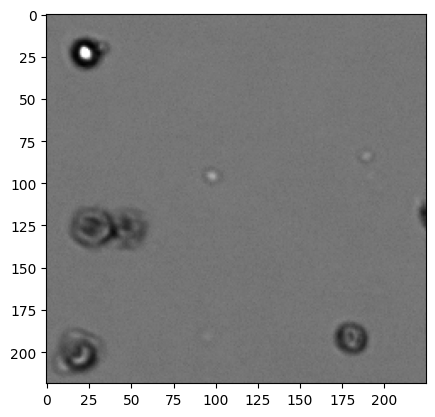

In [ ]:
img = cv2.imread(os.path.join(dataset_dir, png_files[40]))
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(img.shape)
plt.imshow(img,cmap='gray') #BMP IS IMAGE, PNG IS MASK

In [ ]:
p_img = cv2.resize(img,(128,128))

p_img.shape

(128, 128)

In [17]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(png_files, xml_files, test_size=0.35, random_state=42)

In [46]:

###############################
# Define the function to load and preprocess the dataset


def create_dataset(pic_name, dataset_directory):
  #images = []
  #masks = []

  # Define the number of dead and living cells
  living_cell = 0
  dead_cell = 0

  # Normalize the bounding box coordinates
  normalized_bounding_boxes = []

  ##############################

  file_path_img = os.path.join(dataset_directory, pic_name)
  pic_mask = pic_name.split(".")[0] + ".xml"
  file_path_mask = os.path.join(dataset_directory, pic_mask)

  # Load the image and mask using PIL or any other library suitable for your dataset
  # Preprocess the image and mask as needed (e.g., resizing, normalization)


  # Convert the image to a NumPy array
  image = cv2.imread(file_path_img)
  p_img = cv2.resize(image,(128,128))


  # Load the mask using the pandas read xml library
  # Load the XML mask file
  tree = ET.parse(file_path_mask)
  root = tree.getroot()
  #root = pdx.read_xml(os.path.join(dataset_dir, file_path_mask))
  #root = root.pipe(flatten)

  # Create an empty mask with the same shape as the image
  mask = np.zeros_like(p_img[:, :, 0], dtype=np.uint8)

  # Iterate through XML elements to extract bounding box coordinates
  for obj in root.findall('.//object'):
    class_name = obj.find('name').text
    if class_name == 'Living Cell':
      xmin = int(obj.find('bndbox/xmin').text)
      ymin = int(obj.find('bndbox/ymin').text)
      xmax = int(obj.find('bndbox/xmax').text)
      ymax = int(obj.find('bndbox/ymax').text)

      # Set the region defined by the bounding box to 1 in the mask
      mask[ymin:ymax, xmin:xmax] = 1

      # Increment the living cell
      living_cell += 1
    elif class_name == 'Dead Cell':
      xmin = int(obj.find('bndbox/xmin').text)
      ymin = int(obj.find('bndbox/ymin').text)
      xmax = int(obj.find('bndbox/xmax').text)
      ymax = int(obj.find('bndbox/ymax').text)

      # Set the region defined by the bounding box to 1 in the mask
      mask[ymin:ymax, xmin:xmax] = 2

      # Increment the dead cell
      dead_cell += 1

  # Resize labels to match input data shape
  resized_labels = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_LINEAR)


  #images.append(image)
  #masks.append(mask)

  return p_img, resized_labels



In [49]:
from keras.utils import to_categorical
import random
def Generator(X_list, batch_size):
    while True:
        b = 0
        all_i = []
        all_m = []
        random.shuffle(X_list)
        for i in range(batch_size):

            image, mask = create_dataset(X_list[i-1], dataset_dir)
            print("New image shape: ", image.shape)
            all_i.append(image)
            #mask = mask.reshape((128,128,1))
            print("New image shape: ", image.shape)
            print("New mask shape: ", mask.shape)
            all_m.append(mask)
            b+=1

        all_i = np.array(all_i).astype('float32')
        all_m = np.array(all_m).astype('float32')

        # all_i = tf.convert_to_tensor(all_i)
        # tensor_mask = [tf.convert_to_tensor(m) for m in all_m]
        #all_m = tf.convert_to_tensor(all_m)
        #all_i = all_i.astype('float32')
        #all_m = all_m.astype('float32')
        #all_m = to_categorical(all_m)
        #print(all_m[0])
        #print(all_m.shape)

        # Print the shape of the loaded dataset to verify correctness
        #print("Images shape:", all_i.shape)
        #print("Masks shape:", all_m.shape)
        yield all_i, all_m


In [10]:

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPool2D,BatchNormalization,Activation,Input,Conv2DTranspose,Concatenate,concatenate,UpSampling2D,add,SeparableConv2D,MaxPooling2D

In [26]:
####################
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate


def unet_model(input_shape):
    # Input layer
    inputs = Input(input_shape)

    # Downward path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom layer
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Upward path
    up4 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv3))
    merge4 = Concatenate()([conv2, up4])
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge5 = Concatenate()([conv1, up5])
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    output = Conv2D(2, 1, activation='softmax')(conv5)

    model = Model(inputs=inputs, outputs=output)
    return model




In [12]:
# Create the model
#input_shape = (128, 128, 3)  # Adjust the input shape according to your images
input_shape = (128, 128, 3)
#model = unet_model(128, 128, 3)

In [13]:
tf.config.run_functions_eagerly(True)

In [27]:
model_unet = unet_model(input_shape)
#model_unet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')])
model_unet.compile(loss='categorical_crossentropy',optimizer=Adam(), metrics=['accuracy', MeanIoU(num_classes=3, name='IoU')])
model_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_14 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_13[0][0]']           
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_14[0][0]']           
 g2D)                                                                                       

In [ ]:
print(len(X_train))
print(len(X_train)/15)

In [50]:
gen = Generator(X_train, 15)

In [51]:
model_unet.fit(gen, steps_per_epoch=70, epochs = 5)

New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape: 

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape:  (128, 128)
New image shape:  (128, 128, 3)
New image shape:  (128, 128, 3)
New mask shape: 

ValueError: ignored

In [ ]:
im = Image.open(os.path.join(dataset_dir, png_files[30]))

plt.imshow(im)
plt.show()

In [ ]:
im = Image.open(os.path.join(dataset_dir, png_files[40]))

plt.imshow(im)
plt.show()

In [ ]:
# Load the mask using the pandas read xml library
df_1 = pdx.read_xml(os.path.join(dataset_dir, xml_files[40]))
df_1 = df_1.pipe(flatten)

df_1

In [ ]:
df_1 = np.array(df_1)

df_1

In [ ]:

###############################
# Define the function to load and preprocess the dataset


def load_dataset():
  file_names = os.listdir(dataset_dir)
  num_samples = len(file_names)
  images = []
  masks = []

  # Empty lists to hold png and xml files
  png_files = []
  xml_files = []
  files = file_names

  # Loop through the list of files
  for file in files:
    # Check if the file ends with '.png'
    if file.endswith('.png'):
      png_files.append(file)
    # Check if the file ends with '.xml'
    elif file.endswith('.xml'):
      xml_files.append(file)

  # Sort the png and xml files list
  png_files.sort()
  xml_files.sort()

  #print("PNG Files:", len(png_files))
  #print("XML Files:", len(xml_files))

  # Define the number of dead and living cells
  living_cell = 0
  dead_cell = 0

  # Normalize the bounding box coordinates
  normalized_bounding_boxes = []

  ##############################
  for i in range(len(png_files)):
    file_path_img = os.path.join(dataset_dir, png_files[i])
    file_path_mask = os.path.join(dataset_dir, xml_files[i])

    # Load the image and mask using PIL or any other library suitable for your dataset
    # Preprocess the image and mask as needed (e.g., resizing, normalization)


    # Convert the image to a NumPy array
    image = cv2.imread(file_path_img)
    image = Image.fromarray(image)
    image = image.resize((128, 128))
    # Preprocess the image (resize, normalize) as needed
    # image = cv2.resize(image, (128, 128))
    image = np.array(image)
    image = image / 255.0  # Normalize to [0, 1] if necessary

    # Load the mask using the pandas read xml library
    # Load the XML mask file
    tree = ET.parse(file_path_mask)
    root = tree.getroot()
    #root = pdx.read_xml(os.path.join(dataset_dir, file_path_mask))
    #root = root.pipe(flatten)

    # Create an empty mask with the same shape as the image
    mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)


    # Iterate through XML elements to extract bounding box coordinates
    for obj in root.findall('.//object'):
      class_name = obj.find('name').text
      if class_name == 'Living Cell':
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Set the region defined by the bounding box to 1 in the mask
        mask[ymin:ymax, xmin:xmax] = 1

        # Increment the living cell
        living_cell += 1
      elif class_name == 'Dead Cell':
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Set the region defined by the bounding box to 1 in the mask
        mask[ymin:ymax, xmin:xmax] = 2

        # Increment the dead cell
        dead_cell += 1




    images.append(image)
    masks.append(mask)

  return np.array(images), np.array(masks)



In [ ]:
# Load the dataset
images, masks = load_dataset()

# Print the shape of the loaded dataset to verify correctness
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (1756, 128, 128, 3)
Masks shape: (1756, 128, 128)


## Build the Model

In [ ]:
####################
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate


def unet_model(input_shape):
    # Input layer
    inputs = Input(input_shape)

    # Downward path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom layer
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Upward path
    up4 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv3))
    merge4 = Concatenate()([conv2, up4])
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge5 = Concatenate()([conv1, up5])
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    output = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=output)
    return model




In [ ]:
# Create the model
#input_shape = (128, 128, 3)  # Adjust the input shape according to your images
input_shape = images[0].shape
model = unet_model(input_shape)

This implementation follows the U-Net architecture with skip connections.

## Model Training

Now, we'll train the U-Net model using the prepared training dataset.

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.3, random_state=42)

# Normalize pixel values between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = y_train / 255.0
y_test = y_test / 255.0

In [ ]:
y_train.shape

(1229, 128, 128)

In [ ]:
# Compile the model
#model.compile(optimizer='adam', loss=combined_loss(y_train, y_test), metrics=['accuracy', , MeanIoU(num_classes=2, name='IoU')])

model.compile(optimizer=Adam(), loss='binary_crossentropy', \
              metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
# Config Training
BATCH_SIZE = 15
SPE = len(X_train) // BATCH_SIZE

# Training
results = model.fit(
    X_train, y_train,
    validation_split=0.5,
    epochs=15,
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE

)


Epoch 1/15
81/81 [==============================] - 948s 12s/step - loss: 0.0427 - accuracy: 0.9554 - IoU: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9657 - val_IoU: 1.0000
Epoch 2/15
81/81 [==============================] - 938s 12s/step - loss: 0.0024 - accuracy: 0.9679 - IoU: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9657 - val_IoU: 1.0000
Epoch 3/15
81/81 [==============================] - 936s 12s/step - loss: 0.0024 - accuracy: 0.9676 - IoU: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9657 - val_IoU: 1.0000
Epoch 4/15
56/81 [===================>..........] - ETA: 4:04 - loss: 0.0025 - accuracy: 0.9672 - IoU: 1.0000

In [ ]:
# Training
results = model.fit(
    gen,
    validation_split=0.5,
    epochs=15,
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE

)

In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/allfilesproject2023/cell_segmentation_model_.h5')


In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/allfilesproject2023/Cell_Segmentation_Model.h5')



## Model Evaluation

Finally, we'll evaluate the trained model using the testing dataset.

In [ ]:
# Step 4: Model Evaluation
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/allfilesproject2023/cell_segmentation_model_.h5')

model_1 = load_model('/content/drive/MyDrive/allfilesproject2023/Cell_Segmentation_Model.h5')




In [ ]:
# Evaluate the model
loss, accuracy, result = model.evaluate(X_test, y_test)

# Perform segmentation on test images
predicted_masks_ = model.predict(X_test)


In [ ]:
  # Evaluate the model
loss_1, accuracy_1, results = model_1.evaluate(X_test, y_test)

# Perform segmentation on test images
predicted_masks = model.predict(X_test)


Basic implementation of an improved cell segmentation program using U-Net in deep learning.

Experiment it with different model architectures, loss functions, and hyperparameters to further improve the segmentation accuracy.

In [ ]:
import matplotlib.pyplot as plt

# Visualize the segmentation results and compare with ground truth labels
def visualize_segmentation_results(images, masks, predicted_masks):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 10))

    for i in range(num_images):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(predicted_masks[i], cmap='gray')
        axes[i, 2].set_title('Predicted')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you have loaded the test images (X_test), ground truth masks (y_test), and predicted masks (predicted_masks)




In [ ]:
# Select a few random samples for visualization
num_samples = 4
indices = np.random.choice(len(X_test), num_samples, replace=False)

sample_images = X_test[indices]
sample_masks = y_test[indices]
sample_predicted_masks = predicted_masks[indices]

# Visualize the segmentation results
visualize_segmentation_results(sample_images, sample_masks, sample_predicted_masks)

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

In [ ]:
def show_mask(image, mask, cmap=None, alpha=0.4):

    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [ ]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(pred_mask))
        image = images[id]
        mask = masks[id]
        pred_mask = predicted_masks[id]

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# assume y_true is the true binary mask and y_pred is the predicted mask
# both have shape (num_samples, height, width, num_channels)
#y_true = y_val
#y_pred = model.predict(X_val)

predicted_masks

# threshold the predicted mask to convert to binary values
y_true_bool = (y_test > 0.5).astype(bool)
cm = confusion_matrix(y_true_bool.flatten(), predicted_masks.flatten())
cr = classification_report(y_true_bool.flatten(), predicted_masks.flatten())

print("Confusion matrix:")
print(cm)
print("Classification report:")
print(cr)

***Below is the detailed program for the building the model***

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

# Step 1: Data Preparation
def load_data(data_dir, label_dir):
    images = []
    labels = []
    for filename in os.listdir(data_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(data_dir, filename)
            label_path = os.path.join(label_dir, filename)
            image = np.array(Image.open(image_path))
            label = np.array(Image.open(label_path))
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

data_dir = 'path_to_data_directory'  # Replace with your data directory path
label_dir = 'path_to_label_directory'  # Replace with your label directory path

X, y = load_data(data_dir, label_dir)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize pixel values between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = y_train / 255.0
y_test = y_test / 255.0

# Step 2: U-Net Model Architecture
def unet_model(input_shape):
    # Input layer
    inputs = Input(input_shape)

    # Downward path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom layer
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Upward path
    up4 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv3))
    merge4 = Concatenate()([conv2, up4])
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge5 = Concatenate()([conv1, up5])
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    output = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=output)
    return model

input_shape = X_train[0].shape
model = unet_model(input_shape)

# Step 3: Model Training
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

model.fit(X_train, y_train, batch_size=16, epochs=10)

model.save('cell_segmentation_model.h5')

# Step 4: Model Evaluation
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('cell_segmentation_model.h5')

# Evaluate the model
loss, mean_iou = model.evaluate(X_test, y_test)

# Perform segmentation on test images
predicted_masks = model.predict(X_test)

# Visualize the segmentation results and compare with ground truth labels
# You can use matplotlib or other libraries for visualization




*To integrate your dataset:*

1. Place your cell images in a directory and update data_dir variable with the path to that directory.

2. Place your corresponding labeled masks in a separate directory and update label_dir variable with the path to that directory.
3. Make sure the filenames of the cell images and labeled masks are the same, so they can be matched correctly in the load_data function.
4. Remember to adjust the input shape and hyperparameters according to your specific dataset and requirements.

In [ ]:
import matplotlib.pyplot as plt

# Visualize the segmentation results and compare with ground truth labels
def visualize_segmentation_results(images, masks, predicted_masks):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 10))

    for i in range(num_images):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(predicted_masks[i], cmap='gray')
        axes[i, 2].set_title('Predicted')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you have loaded the test images (X_test), ground truth masks (y_test), and predicted masks (predicted_masks)

# Select a few random samples for visualization
num_samples = 5
indices = np.random.choice(len(X_test), num_samples, replace=False)

sample_images = X_test[indices]
sample_masks = y_test[indices]
sample_predicted_masks = predicted_masks[indices]

# Visualize the segmentation results
visualize_segmentation_results(sample_images, sample_masks, sample_predicted_masks)


*In the code above, a function called visualize_segmentation_results was created*

 It takes the test images, ground truth masks, and predicted masks as input. It then uses matplotlib to plot a grid of three images side by side for each sample: the original image, the ground truth mask, and the predicted mask. We use a random sample of images from the test set for visualization.

You may need to modify the code according to your specific variable names and dataset structure. Additionally, you can customize the visualization as per your requirements, such as adjusting the figure size, adding color maps, or modifying the layout.

Make sure to have the matplotlib library installed before running the code. You can install it using pip install matplotlib.

# New

In [ ]:
setup_gpu()

In [ ]:
dataset_dir
import tensorflow.compat.v2 as tf
#tf.disable_v2_behavior()
print(tf.version)

In [ ]:
import tensorflow as tf
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
categorical_crossentropy = tf.keras.losses.CategoricalCrossentropy()

def smooth_l1_loss(y_train, y_test):
    abs_diff = tf.abs(y_train - y_test)
    smooth_l1_loss = tf.where(abs_diff < 1, 0.5 * tf.square(abs_diff), abs_diff - 0.5)
    return tf.reduce_sum(smooth_l1_loss, axis=-1)

def combined_loss(y_train, y_test):
    # Extract the ground truth bounding box coordinates and class labels
    y_train_bbox = y_train[..., :4]
    y_train_class = y_train[..., 4:]

    # Extract the predicted bounding box coordinates and class probabilities
    y_test_bbox = y_test[..., :4]
    y_test_class = y_test[..., 4:]

    # Compute the bounding box regression loss
    bbox_loss = smooth_l1_loss(y_train_bbox, y_test_bbox)

    # Compute the classification loss
    class_loss = binary_crossentropy(y_train_class, y_test_class)

    # Combine the two losses into a single loss value
    return bbox_loss + class_loss


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D

@tf.function
def conv2d_block(input_tensor, n_filters):
    model = tf.keras.Sequential()
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    model.add(tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (3, 3),\
                                     activation='relu', input_shape=input_tensor.shape[1:]))

    # second layer
    model.add(tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    x = MaxPooling2D((2, 2))(model.output)
    return x



@tf.function
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Convert input_img to a tensor
    input_tensor = tf.convert_to_tensor(input_img)

    # Pass input_tensor to conv2d_block function
    # Contracting Path
    c1 = conv2d_block(input_tensor, n_filters * 1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', name="conv1" )(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', name="conv2")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)


    return x




import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model

def add_conv_layers(input_tensor, n_filters=32, kernel_size=5, batchnorm=True):
    conv1 = Conv2D(filters=n_filters, kernel_size=(5, 5),  \
                   padding="same", activation=tf.nn.relu)(input_tensor)
    conv2 = Conv2D(filters=64, kernel_size=(5, 5), padding="same", activation=tf.nn.relu)(conv1)
    return conv2

input_tensor = tf.keras.layers.Input(shape=(128, 128, 3))
output_tensor = add_conv_layers(input_tensor)

model = Model(inputs=input_tensor, outputs=output_tensor)


import tensorflow as tf

def create_convolutional_model(input_tensor):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_tensor))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    return model



In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
# Define the function to load and preprocess the dataset
def load_dataset():
    file_names = os.listdir(dataset_dir)
    num_samples = len(file_names)
    images = []
    masks = []

    # Empty lists to hold png and xml files
    png_files = []
    xml_files = []
    files = file_names
    # Loop through the list of files
    for file in files:
        # Check if the file ends with '.png'
        if file.endswith('.png'):
            png_files.append(file)
        # Check if the file ends with '.xml'
        elif file.endswith('.xml'):
            xml_files.append(file)

    # Sort the png and xml files list
    png_files.sort()
    xml_files.sort()

    # Normalize the bounding box coordinates
    normalized_bounding_boxes = []

    for i in range(len(png_files)):
        file_path_img = os.path.join(dataset_dir, png_files[i])
        file_path_mask = os.path.join(dataset_dir, xml_files[i])

        # Load the image and mask using PIL or any other library suitable for your dataset

        image = cv2.imread(file_path_img)

        # Load the mask using the pandas read xml library
        mask = pdx.read_xml(os.path.join(dataset_dir, file_path_mask))
        mask = mask.pipe(flatten)


        # Convert the image to a NumPy array



        # Preprocess the image and mask as needed (e.g., resizing, normalization)
        image = Image.fromarray(image)
        image = image.resize((128, 128))
        image = np.array(image)


        # convert mask to numpy
        mask = mask.to_numpy()

        # Extract the width and height of the image
        image_width = float(mask[0][4]['width'])
        image_height = float(mask[0][4]['height'])

        # Extract the bounding box data
        bounding_boxes = []
        try:
          bounding_boxes.append(mask[0][6])
        except:
          print(f"the file {i} does not include bounding box features")
          continue


        try:
          for bbox in bounding_boxes:
            xmin = float(bbox['bndbox']['xmin']) / image_width
            ymin = float(bbox['bndbox']['ymin']) / image_height
            xmax = float(bbox['bndbox']['xmax']) / image_width
            ymax = float(bbox['bndbox']['ymax']) / image_height
          normalized_bounding_boxes.append([xmin, ymin, xmax, ymax])

        except:
          for j in range(len(bounding_boxes)):
            bbox = bounding_boxes[j]
          for k in range(len(bbox)):
            xmin = float(bbox[k]['bndbox']['xmin']) / image_width
            ymin = float(bbox[k]['bndbox']['ymin']) / image_height
            xmax = float(bbox[k]['bndbox']['xmax']) / image_width
            ymax = float(bbox[k]['bndbox']['ymax']) / image_height
          normalized_bounding_boxes.append([xmin, ymin, xmax, ymax])




        # Convert the list to a NumPy array
        normalized_mask = np.array(normalized_bounding_boxes)

        images.append(image)
        masks.append(normalized_mask)

    return np.array(images), np.array(normalized_mask)

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import xml.etree.ElementTree as ET

# Define the function to load and preprocess the dataset
def load_dataset(dataset_dir):
    file_names = os.listdir(dataset_dir)
    num_samples = len(file_names)
    images = []
    masks = []

    # Loop through the list of files
    for file in file_names:
        # Check if the file ends with '.png'
        if file.endswith('.png'):
            file_path_img = os.path.join(dataset_dir, file)
            file_path_mask = os.path.join(dataset_dir, file.replace('.png', '.xml'))

            # Load the image using OpenCV
            image = cv2.imread(file_path_img)

            # Load the XML mask file
            tree = ET.parse(file_path_mask)
            root = tree.getroot()

            # Create an empty mask with the same shape as the image
            mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)

            # Iterate through XML elements to extract bounding box coordinates
            for obj in root.findall('.//object'):
                class_name = obj.find('name').text
                if class_name == 'living_cell' or class_name == 'dead_cell':
                    xmin = int(obj.find('bndbox/xmin').text)
                    ymin = int(obj.find('bndbox/ymin').text)
                    xmax = int(obj.find('bndbox/xmax').text)
                    ymax = int(obj.find('bndbox/ymax').text)

                    # Set the region defined by the bounding box to 1 in the mask
                    mask[ymin:ymax, xmin:xmax] = 1

            # Preprocess the image (resize, normalize) as needed
            image = cv2.resize(image, (128, 128))
            image = image / 255.0  # Normalize to [0, 1] if necessary

            images.append(image)
            masks.append(mask)

    return np.array(images), np.array(masks)

# Example usage:
dataset_dir = "your_dataset_directory_here"
images, masks = load_dataset(dataset_dir)


In [ ]:
# Define the function to load and preprocess the dataset

def load_dataset(dataset_dir):
  file_names = os.listdir(dataset_dir)
  num_samples = len(file_names)
  images = []
  masks  = []

  # Empty lists to hold png and xml files
  png_files = []
  xml_files = []
  files = file_names

  # Loop through the list of files
  for file in files:
    # Check if the file ends with '.png'
    if file.endswith('.png'):
      png_files.append(file)
    # Check if the file ends with '.xml'
    elif file.endswith('.xml'):
      xml_files.append(file)

  # Sort the png and xml files list
  png_files.sort()
  xml_files.sort()

  # Normalize the bounding box coordinates
  normalized_bounding_boxes = []

  ##############################
  for i in range(len(png_files)):
    file_path_img = os.path.join(dataset_dir, png_files[i])
    file_path_mask = os.path.join(dataset_dir, xml_files[i])

  # Load the image and mask using PIL or any other library suitable for your dataset
	# Preprocess the image and mask as needed (e.g., resizing, normalization)
    image = cv2.imread(file_path_img)
  	image = Image.fromarray(image)
    image = image.resize((128, 128))
    # Convert the image to a NumPy array
    # Preprocess the image (resize, normalize) as needed
    # image = cv2.resize(image, (128, 128))
    image = np.array(image)
    image = image / 255.0  # Normalize to [0, 1] if necessary

    # Load the mask using the pandas read xml library
    root = pdx.read_xml(os.path.join(dataset_dir, file_path_mask))
    root = mask.pipe(flatten)

    # Create an empty mask with the same shape as the image
    mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)

    # Iterate through XML elements to extract bounding box coordinates
    for obj in root.findall('.//object'):
      class_name = obj.find('name').text
      if class_name == 'living_cell':
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Set the region defined by the bounding box to 1 in the mask
        mask[ymin:ymax, xmin:xmax] = 1
      else:
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Set the region defined by the bounding box to 1 in the mask
        mask[ymin:ymax, xmin:xmax] = 2



    images.append(image)
    masks.append(mask)

    return np.array(images), np.array(masks)



In [ ]:
# Define the function to load and preprocess the dataset
def load_dataset():
    file_names = os.listdir(dataset_dir)
    num_samples = len(file_names)
    images = []
    masks = []

    # Empty lists to hold png and xml files
    png_files = []
    xml_files = []
    files = file_names
    # Loop through the list of files
    for file in files:
        # Check if the file ends with '.png'
        if file.endswith('.png'):
            png_files.append(file)
        # Check if the file ends with '.xml'
        elif file.endswith('.xml'):
            xml_files.append(file)

    # Sort the png and xml files list
    png_files.sort()
    xml_files.sort()

    # Normalize the bounding box coordinates
    normalized_bounding_boxes = []

    for i in range(len(png_files)):
        file_path_img = os.path.join(dataset_dir, png_files[i])
        file_path_mask = os.path.join(dataset_dir, xml_files[i])

        # Load the image and mask using PIL or any other library suitable for your dataset

        image = cv2.imread(file_path_img)

        # Load the mask using the pandas read xml library
        mask = pdx.read_xml(os.path.join(dataset_dir, file_path_mask))
        mask = mask.pipe(flatten)


        # Convert the image to a NumPy array
        #image = np.array(image)


        # Preprocess the image and mask as needed (e.g., resizing, normalization)
        image = Image.fromarray(image)
        image = image.resize((128, 128))
        image = np.array(image)


        # convert mask to numpy
        mask = mask.to_numpy()

        # Extract the width and height of the image
        image_width = float(mask[0][4]['width'])
        image_height = float(mask[0][4]['height'])

        # Extract the bounding box data
        bounding_boxes = []
        try:
          bounding_boxes.append(mask[0][6])
        except:
          print(f"the file {i} does not include bounding box features")
          continue


        try:
          for bbox in bounding_boxes:
            xmin = float(bbox['bndbox']['xmin']) / image_width
            ymin = float(bbox['bndbox']['ymin']) / image_height
            xmax = float(bbox['bndbox']['xmax']) / image_width
            ymax = float(bbox['bndbox']['ymax']) / image_height
          normalized_bounding_boxes.append([xmin, ymin, xmax, ymax])
              #print("done!")
        except:
          #print(len(bounding_boxes))
          for j in range(len(bounding_boxes)):
            #print(bounding_boxes[j])
            bbox = bounding_boxes[j]
            #print(type(bbox))
          for k in range(len(bbox)):
            xmin = float(bbox[k]['bndbox']['xmin']) / image_width
            ymin = float(bbox[k]['bndbox']['ymin']) / image_height
            xmax = float(bbox[k]['bndbox']['xmax']) / image_width
            ymax = float(bbox[k]['bndbox']['ymax']) / image_height
          normalized_bounding_boxes.append([xmin, ymin, xmax, ymax])
            #print("Donee!!")
            #if bbox['bndbox'] != 0:
              #print(bbox)
          #break

        # for j in range(len(bounding_boxes)):


        # Convert the list to a NumPy array
        normalized_mask = np.array(normalized_bounding_boxes)

        # mask = Image.fromarray(mask)
        # mask = mask.resize((128, 128))
        # mask = np.array(mask)

        # Normalize pixel values if required
        #image = image / 255.0
        #mask = mask / 255.0

        # Expand dimensions if necessary (e.g., for grayscale images)
        #if len(image.shape) == 2:
         # image = np.expand_dims(image, axis=-1)

        #if len(mask.shape) == 2:
         # mask = np.expand_dims(mask, axis=-1)

        # Append the preprocessed image and mask to the respective lists
        images.append(image)
        masks.append(normalized_mask)

    return np.array(images), np.array(normalized_mask)

In [ ]:
# Define the function to load and preprocess the dataset
def load_dataset():
    file_names = os.listdir(dataset_dir)
    num_samples = len(file_names)
    images = []
    masks = []

    # Empty lists to hold png and xml files
    png_files = []
    xml_files = []
    files = file_names
    # Loop through the list of files
    for file in files:
        # Check if the file ends with '.png'
        if file.endswith('.png'):
            png_files.append(file)
        # Check if the file ends with '.xml'
        elif file.endswith('.xml'):
            xml_files.append(file)

    # Sort the png and xml files list
    png_files.sort()
    xml_files.sort()

    #pop the last list
    #png_files.pop()
    #xml_files.pop()

    # Normalize the bounding box coordinates
    normalized_bounding_boxes = []

    for i in range(len(png_files)):
        file_path_img = os.path.join(dataset_dir, png_files[i])
        file_path_mask = os.path.join(dataset_dir, xml_files[i])

        # Load the image and mask using PIL or any other library suitable for your dataset

        image = cv2.imread(file_path_img)

        # Load the mask using the pandas read xml library
        mask = pdx.read_xml(os.path.join(dataset_dir, file_path_mask))
        mask = mask.pipe(flatten)


        # Convert the image to a NumPy array
        #image = np.array(image)


        # Preprocess the image and mask as needed (e.g., resizing, normalization)
        image = Image.fromarray(image)
        # Convert the image to grayscale
        image = image.resize((128, 128))
        image = np.array(image)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # The resulting grayscale image will have shape (128, 128)
        # If you want the shape to be (128, 128, 1), you can add a third dimension
        gray_image_array = gray_image[:, :, np.newaxis]
        #image = image.resize((128, 128))
        #image = np.array(image)


        # convert mask to numpy
        mask = mask.to_numpy()

        # Extract the width and height of the image
        image_width = float(mask[0][4]['width'])
        image_height = float(mask[0][4]['height'])

        # Extract the bounding box data
        bounding_boxes = []
        try:
          bounding_boxes.append(mask[0][6])
        except:
          print(f"the file {i} does not include bounding box features")
          continue


        try:
          for bbox in bounding_boxes:
            xmin = float(bbox['bndbox']['xmin']) / image_width
            ymin = float(bbox['bndbox']['ymin']) / image_height
            xmax = float(bbox['bndbox']['xmax']) / image_width
            ymax = float(bbox['bndbox']['ymax']) / image_height
          normalized_bounding_boxes.append([xmin, ymin, xmax, ymax])
              #print("done!")
        except:
          #print(len(bounding_boxes))
          for j in range(len(bounding_boxes)):
            #print(bounding_boxes[j])
            bbox = bounding_boxes[j]
            #print(type(bbox))
          for k in range(len(bbox)):
            xmin = float(bbox[k]['bndbox']['xmin']) / image_width
            ymin = float(bbox[k]['bndbox']['ymin']) / image_height
            xmax = float(bbox[k]['bndbox']['xmax']) / image_width
            ymax = float(bbox[k]['bndbox']['ymax']) / image_height
          normalized_bounding_boxes.append([xmin, ymin, xmax, ymax])
            #print("Donee!!")
            #if bbox['bndbox'] != 0:
              #print(bbox)
          #break
        # Reshape the grayscale image array to have shape (128, 128, 1)
        #gray_image_array = gray_image_array.reshape((128, 128, 1))

        # Convert the list to a NumPy array
        normalized_mask = np.array(normalized_bounding_boxes)

        # Convert the image to grayscale using a weighted average
        #gray_image_array = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

        # Reshape the grayscale image array to have shape (128, 128, 1)
        #gray_image_array = gray_image_array.reshape((128, 128, 1))

        # Expand dimensions if necessary (e.g., for grayscale images)
        # if len(image.shape) == 2:
        #   image = np.expand_dims(image, axis=-1)

        if len(normalized_mask.shape) == 2:
          normalized_mask = np.expand_dims(normalized_mask, axis=-1)


        # Append the preprocessed image and mask to the respective lists
        images.append(gray_image_array)
        masks.append(normalized_mask)

    return np.array(images), np.array(normalized_mask)